# Background

For this proof of concept, I  would like to examine if weather parameters can predict the number of visits to a particular ice cream store. The store is a specialty ice cream store located in Somerville, Massachusetts called the  "[Tipping Cow](https://www.tippingcowicecream.com)". It's a neighborhood favorite and claims to use only natural ingredients in its products. 

Foot-traffic data were obtained from SafeGraph's [patterns](https://docs.safegraph.com/v4.0/docs/places-schema#section-patterns) and weather data (GHCN-daily) were obtained from the [NOAA website](https://www.ncdc.noaa.gov/ghcn-daily-description). And please see the data dictionary of the variables used in this analysis [here](https://drive.google.com/file/d/1d2lGBzz9DQtp9IFCfvu0xk4hRxV0tAsz/view?usp=sharing).

Some data processing was done before creating this Colab presentation. Specifically, store visits were broken up from monthly to daily. For weather data, because stations don't have full coverage of different aspects of weather, the store's county was selected (Middlesex county, MA) and a pivot table (mean-values) was created for all weather stations in the county. The year selected was 2018. 

# Data preparation

In [ ]:
# install necessary pacakges
!pip install statsmodels==0.12.1
from scipy import stats, special, fft, signal as sig
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
%matplotlib inline

In [ ]:
#download data from google shareable links
!gdown --id 1dBnFVckgr2OP5nnyWSB4Vkfpa6SROn7f
!gdown --id 1lQc3tK4ujp9HZJl2cerlBBeHpULdHcat

Downloading...
From: https://drive.google.com/uc?id=1dBnFVckgr2OP5nnyWSB4Vkfpa6SROn7f
To: /content/day_visits_2018.csv
100% 596k/596k [00:00<00:00, 39.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1lQc3tK4ujp9HZJl2cerlBBeHpULdHcat
To: /content/weather_pivot.csv
100% 60.5k/60.5k [00:00<00:00, 22.6MB/s]


In [ ]:
#import data
visits_df = pd.read_csv("day_visits_2018.csv")
weather_df = pd.read_csv("weather_pivot.csv")

        trend
0    0.333333
1    0.238095
2    0.095238
3    0.428571
4    0.428571
..        ...
360  0.333333
361  0.095238
362  0.190476
363  0.238095
364  0.095238

[365 rows x 1 columns]


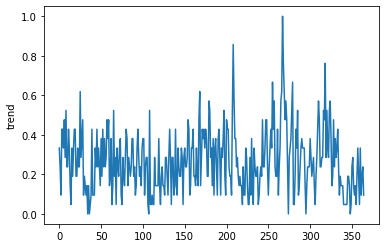

In [ ]:
# check the pattern for visits throughout the year

visits = visits_df['day_visit_counts']
visits_p= visits/max(visits)  #scale y as a proportion to the max visits within a day in the year
signal = list(visits_p)
signal_df = pd.DataFrame(signal)
signal_df.columns = ['trend']
print(signal_df)
sns.lineplot(x=signal_df.index, y=signal_df['trend'])

# Analysis

In [ ]:
# Select the best weather features using kbestfeatures

weather_vars = weather_df.drop(columns = ['DATE'])  #select only the weather variables
weather_vars = weather_vars.fillna(0)  # fill missing data with 0s
scaled_weather = weather_vars/weather_vars.max()  #also scale the weather variables to be proportional to the max value in the columns
X = scaled_weather
y = signal
winning_model = None
winning_score = -999
for k in range(1, 15):
  fs = SelectKBest(score_func=f_regression, k=k)
  X_selected = fs.fit_transform(X, y)
  filter = fs.get_support()
  weather_selected = scaled_weather[scaled_weather.columns[filter]]
  x = weather_selected
  y = signal
  x = sm.add_constant(x)
  lr_model = sm.OLS(y, x).fit()
  if lr_model.f_pvalue <= 0.05 and lr_model.rsquared_adj > winning_score:  #select the best model
    winning_score = lr_model.rsquared_adj
    winning_model = lr_model
print(winning_model.summary(), winning_score)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     3.137
Date:                Sat, 28 Nov 2020   Prob (F-statistic):             0.0446
Time:                        22:47:53   Log-Likelihood:                 158.93
No. Observations:                 365   AIC:                            -311.9
Df Residuals:                     362   BIC:                            -300.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2252      0.021     10.556      0.0

We can see that the model adjusted R-squared is only 0.012. This gives the model very little explanatory power. The two coefficients are also non-significant. 

# Check for Gauss-Markov assumptions

The Gauss_markov assumptions to assess regression models are as follows: 


<u>Linearity:</u> the parameters we are estimating using the OLS method must be linear. \
<u>Random:</u> our data must have been randomly sampled from the population. \
<u>Non-Collinearity:</u> the regressors being calculated aren’t perfectly correlated with each other. \
<u>Exogeneity:</u> the regressors aren’t correlated with the error term. \
<u>Homoscedasticity:</u> no matter what the values of our regressors might be, the error of the variance is constant.

Below, several functions are built to check if the best model found above satisfies these assumptions.

In [ ]:
from scipy.stats import pearsonr, bartlett, levene, shapiro, normaltest, boxcox, PearsonRConstantInputWarning
from warnings import simplefilter
from statsmodels.tsa.stattools import acf

In [ ]:
def calculate_residuals(model, X, y, y_substitute=None):
    X = sm.add_constant(X)
    predictions = model.predict(X)
    residuals = y - predictions
    return residuals 

In [ ]:
def has_multicolinearity(X, colinearity_threshold=0.6, ignore_nan=True, verbose=False):
    columns = X.columns
    print(f"Testing for multicolinearity with a threshold of: {str(colinearity_threshold)}.", verbose)
    for column_under_test in columns:
        for column in columns:
            if column_under_test == column:
                continue

            simplefilter("ignore", PearsonRConstantInputWarning)
            result = pearsonr(X[column_under_test], X[column])
            simplefilter("default", PearsonRConstantInputWarning)
            if np.isnan(result[0]) and not ignore_nan:
                print('Constant detected, and ignore_nan is False. Model', verbose)
                return True
            elif np.isnan(result[0]):
                continue 

            if abs(result[0]) >= colinearity_threshold:
                print('Multicolinearity detected.', verbose)
                return True
    
    print('No multicolinearity within the threshold detected.', verbose)
    return False

In [ ]:
def normal_test(X, ha_threshold=0.05, verbose=False):
    print(f"Testing the null hypothesis that the input is normally distributed with an alpha of {str(ha_threshold)}", verbose)
    result = shapiro(X)
    if ha_threshold >= result[1]:
        print(f"The p-value of the result is {str(result[1])}, at or below the threshold of {str(ha_threshold)}, therefore we reject the null hypothesis and accept the alternate hypothesis that the input is not normally distributed.", verbose)
        return False

    print(f"The p-value of the result is {str(result[1])}, above the threshold of {str(ha_threshold)}, therefore we cannot reject the null hypothesis and accept that the input is normally distributed.", verbose)
    return True

In [ ]:
def errors_autocorrelate(residuals, autocorrelation_threshold=0.6, nlags=40, fft=False, verbose=False):
    print(f"Testing if errors are autocorrelated with a threshold of {str(autocorrelation_threshold)} for up to {str(nlags)}.", verbose)
    result = acf(residuals, nlags=nlags, fft=fft)
    test = abs(result[1:]) >= autocorrelation_threshold
    if True in test:
        print(f"Autocorrelation at or above the threshold detected.", verbose)
        return True

    print(f"Autocorrelation at or above the threshold not detected.", verbose)
    return False

In [ ]:
def error_features_correlate(residuals, X, correlation_threshold=0.6, verbose=False):
    print(f"Testing that errors and features are not correlated with a threshold of {str(correlation_threshold)} or higher.", verbose)
    for column in X.columns:
        a = X[column].to_numpy()
        if (a[0] == a).all():
            continue
        result = pearsonr(residuals, X[column])
        if abs(result[0]) >= correlation_threshold:
            print(f"Correlation between errors and features at or above the treshold detected in column: {column}", verbose)
            return True

    print(f"Correlation between errors and features at or above the treshold detected in column: {column}", verbose)
    return False 

In [ ]:
def is_homoscedastic(residuals, y, ha_threshold=0.05, verbose=False):
    print(f"Testing for homoscedasticity with an alpha of: {str(ha_threshold)}. The null hypothesis is that the errors are homoscedastic.", verbose)
    result = bartlett(residuals, y)
    if ha_threshold >= result[1]:
        print(f"P-value for Bartlett test is {str(result[1])} which is at or below the threshold. We therefore reject the null hypothesis and accept the errors are heteroscedastic.", verbose)
        return False

    print(f"P-value for Bartlett test is {str(result[1])} which is greater than the threshold. We therefore do not reject the null hypothesis and accept the errors are homoscedastic.", verbose)
    return True

In [ ]:
def satisfies_gauss_markov(model, dataset, verbose=True):
    X_train, _, y_train, _ = dataset
    residuals = calculate_residuals(model, X_train, y_train)
    no_multicolinearity = not has_multicolinearity(X_train, verbose=verbose)
    normal_errors = normal_test(residuals, verbose=verbose)
    no_autocorrelation = not errors_autocorrelate(residuals, verbose=verbose)
    no_error_feature_correlation = not error_features_correlate(residuals, X_train, verbose=verbose)
    homoscedasticity = is_homoscedastic(residuals, y_train, verbose=verbose)
    return [homoscedasticity, no_multicolinearity, normal_errors, no_autocorrelation, no_error_feature_correlation]

In [ ]:
# select weather columns from original data that are relevant for the model
weather_X = scaled_weather[["PRCP", "TMIN"]]

In [ ]:
# split to train and test data
dataset = train_test_split(weather_X, y, test_size=0.33, random_state=42)

In [ ]:
satisfies_gauss_markov(winning_model, dataset)

Testing for multicolinearity with a threshold of: 0.6. True
No multicolinearity within the threshold detected. True
Testing the null hypothesis that the input is normally distributed with an alpha of 0.05 True
The p-value of the result is 2.0178044906060677e-06, at or below the threshold of 0.05, therefore we reject the null hypothesis and accept the alternate hypothesis that the input is not normally distributed. True
Testing if errors are autocorrelated with a threshold of 0.6 for up to 40. True
Autocorrelation at or above the threshold not detected. True
Testing that errors and features are not correlated with a threshold of 0.6 or higher. True
Correlation between errors and features at or above the treshold detected in column: TMIN True
Testing for homoscedasticity with an alpha of: 0.05. The null hypothesis is that the errors are homoscedastic. True
P-value for Bartlett test is 0.9299139186162817 which is greater than the threshold. We therefore do not reject the null hypothesis a

[True, True, False, True, True]

We can see that all assumptions were met but not for the "normal errors" assumption. Although the Gauss-Markov theorem does not explicitly require errors to be normally distributed, a deviation of normality might make the results inaccurate.

# Concluion

Given the model performance, it is hard to state there is much correlation between weather and customer visits to the ice cream store. However, this specialty store might not be representative of a wide variety of ice cream stores as it is more of a mom and pop store, which might have a loyal client base who wouldn't base their decisions of getting ice cream on the weather on a particular day. In the next step, I will look at all ice cream stores in the greater Boston area and examine if the weather would predict store visits aggregately.  